<a href="https://colab.research.google.com/github/valmirf/redes_neurais_esp/blob/main/PyTorch/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmentação Semântica

Refere-se ao processo de classificação de cada pixel em uma imagem a um rótulo de classe. Esses rótulos são os objetos que se destacam em uma imagem, como pessoas, uma célula, uma árvore, um carro, só pra citar alguns. Esse tipo de segmentação pode ser muito útil em aplicações ​​para contar o número de objetos, como a contagem do tráfego de pedestres em um shopping, número de células numa imagem, etc. Pra mais informações, veja este artigo no [medium](https://heartbeat.fritz.ai/a-2019-guide-to-semantic-segmentation-ca8242f5a7fc).

In [1]:
import os
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2
from albumentations.pytorch import ToTensor
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from PIL import Image
from torch import nn
import tarfile
import warnings
import random
import sys
import gc
from tqdm import tqdm
from tqdm import trange

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Carregando a Base de Dados

In [3]:
#path = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Dataset')   # Change according to your path 
path = os.path.join(os.getcwd())   # Change according to your path
os.chdir(path)
print('path: ' + path)
zip_path = path + '/gdrive/My Drive/Dataset'

#path = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Dataset')   # Change according to your path 
path = os.path.join(os.getcwd())   # Change according to your path
os.chdir(path)

if(not os.path.isdir(path + '/data/stage1_train/')):
  with tarfile.open(zip_path + '/data-science-bowl-2018.tar', 'r:tar') as tar:
      tar.extractall('data')



path: /content


## Carrega a Base de Dados

O código abaixo manipula os dados extraídos e cria a estrutura de uma Base de Dados ao invocar `Dataset` no construtor. No método `__init__` a base de dados é carregada na variável `data`, que carrega as imagens e na variável `mask` que carrega as máscaras das imagens. O método `__getitem__` retorna uma tupla (imagem, máscara).

In [5]:
'''
def get_transforms(mean, std):
            list_transforms = []
            
            list_transforms.extend(
                    [
                HorizontalFlip(p=0.5), # only horizontal flip as of now
                    ])
            list_transforms.extend(
                    [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
                    ])
            list_trfms = Compose(list_transforms)
            return list_trfms
'''

class Nuclie_data(Dataset):
        def __init__(self,path):
            self.path = path
            #self.transforms = get_transforms(0.5, 0.5)

            # Set some parameters
            IMG_WIDTH = 128
            IMG_HEIGHT = 128
            IMG_CHANNELS = 3
            width_out = 128
            height_out = 128
            TRAIN_PATH = '/content/data/stage1_train/'
            TEST_PATH = '/content/data/stage1_test/'

            self.folders = os.listdir(TRAIN_PATH)

            warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
            seed = 42
            random.seed = seed
            np.random.seed = seed
 
            # Get train and test IDs
            train_ids = next(os.walk(TRAIN_PATH))[1]
            test_ids = next(os.walk(TEST_PATH))[1]

            # Get and resize train images and masks
            x_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
            y_train = np.zeros((len(train_ids), height_out, width_out, 1), dtype=np.bool)
            print('Getting train images and masks ... ')
            sys.stdout.flush()
            for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
                path = TRAIN_PATH + id_
                img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
                img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                x_train[n] = img
                mask = np.zeros((height_out, width_out, 1), dtype=np.bool)
                for mask_file in next(os.walk(path + '/masks/'))[2]:
                    mask_ = imread(path + '/masks/' + mask_file)
                    mask_ = np.expand_dims(resize(mask_, (height_out, width_out), mode='constant', 
                                                  preserve_range=True), axis=-1)
                    mask = np.maximum(mask, mask_)
                y_train[n] = mask



            # Get and resize test images
            x_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
            sizes_test = []
            print('Getting and resizing test images ... ')
            sys.stdout.flush()
            for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
                path = TEST_PATH + id_
                img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
                sizes_test.append([img.shape[0], img.shape[1]])
                img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                x_test[n] = img

            #herança da classe Dataset
            self.data = x_train
            self.mask = y_train

            self.data_test = x_test
            

            print('Done!')

        
        def __len__(self):
            return len(self.folders)
              
        
        def __getitem__(self,idx):
            item = self.data[idx].transpose(2, 0, 1)
            label = self.mask[idx].transpose(2, 0, 1)

            #if self.transforms is not None:
            #   item_as_tensor = tf.convert_to_tensor(item)

            if label is not None:
                return item,label
            else:
                return item
                
#loading the data
base_dir = path + '/data/' 
data = Nuclie_data(base_dir)

# splitting to trainset and validation set and loading the data with batch size of 10
print(data)
trainset, valset = random_split(data, [580, 90])

train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=10, shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=10)

Getting train images and masks ... 


100%|██████████| 670/670 [06:37<00:00,  1.68it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:02<00:00, 31.59it/s]


Done!


## Algumas Funções Úteis
Abaixo algumas funções úteis para plotar as imagens da base de dados e suas máscaras. 

670
(3, 128, 128)
(1, 128, 128)


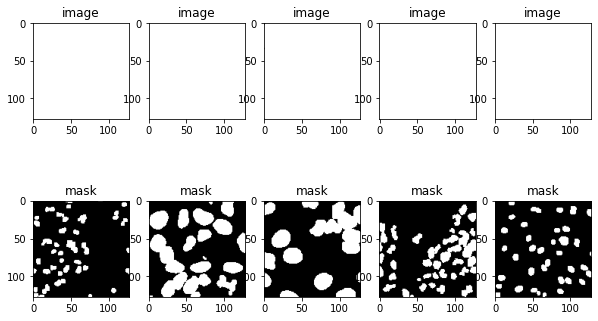

In [9]:
# print out some sample data
print(data.__len__())
data.__getitem__(0)

for img,msk in data:
  #img = img.reshape(3, 128, 128)
  #img = img.transpose(2, 0, 1)
  #msk = msk.transpose(2, 0, 1)
  print(img.shape)
  print(msk.shape)
  break
  
# some utility functions
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask  = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(no_):
    iter_ = iter(train_loader)
    images,masks = next(iter_)
    images = images.to(device)
    masks = masks.to(device)
    plt.figure(figsize=(10,6))
    for idx in range(0,no_):
         image = image_convert(images[idx])
         plt.subplot(2,no_,idx+1)
         plt.title('image')
         plt.imshow(image)
    for idx in range(0,no_):
         mask = mask_convert(masks[idx])
         plt.subplot(2,no_,idx+no_+1)
         plt.title('mask')
         plt.imshow(mask,cmap='gray')
    plt.show()

# we will try visualizing images and corresponding masks
plot_img(5)

##2. Unet
Unet e uma Rede neural de segmentação semântica amplamente utilizada e alterada na literatura pra diversos problemas de segmentação

A arquitetura do Unet pode ser dividida em duas partes esquerda (caminho de contratação) e direita (caminho de expansão).

![](https://github.com/valmirf/redes_neurais_esp/blob/main/PyTorch/FIG/Unet.png?raw=true)

A parte esquerda da rede Unet é apenas uma rede de convolução simples. Na parte esquerda duas camadas de convolução 3x3 seguidas por uma função de ativação Relu são empilhadas juntas (sequencialmente) e uma camada maxpool 2x2 é aplicada depois disso (**seta vermelha** na imagem). A primeira barra vertical no lado esquerdo da imagem não é uma camada, mas representa a entrada (bloco da imagem de entrada).

A parte direita é onde a mágica acontece. A parte direita também usa duas camadas de convolução 3x3 empilhadas juntas (sequencialmente) como o lado esquerdo, mas nenhuma função de ativação Relu é usada e não há nenhuma camada maxpool usada. No lugar dessas camadas, é utilizada uma camada de convolução 2x2 Transposta (**seta verde** na imagem). Durante o caminho de expansão, a imagem é copiada (cópia) do lado esquerdo e combinada com a imagem da direita (**seta cinza** na imagem). 

As camadas de convolução 3x3 sequenciais também são usadas no lado direito, de modo que a entrada para delas será a combinação da imagem da direita e sua camada anterior (metade da caixa branca e azul no lado direito da imagem é a combinação).

In [10]:
#Seta azul - Convolução
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.dblock1 = double_conv(3, 64)
        self.dblock2 = double_conv(64, 128)
        self.dblock3 = double_conv(128,256)
        self.dblock4 = double_conv(256,512)

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) 

        self.dblock5 = double_conv(256 + 512, 256)
        self.dblock6 = double_conv(128 + 256, 128)
        self.dblock7 = double_conv(128 + 64, 64)

        self.last_layer = nn.Conv2d(64,1,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        conv1 = self.dblock1(x)
        x = self.pool(conv1)

        conv2 = self.dblock2(x)
        x = self.pool(conv2)

        conv3 = self.dblock3(x)
        x = self.pool(conv3)

        conv4 = self.dblock4(x)
        
        x = self.upsample(conv4)

        x = torch.cat([x, conv3], dim=1)

        x = self.dblock5(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        
        x = self.dblock6(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        
        x = self.dblock7(x)

        out = self.last_layer(x)
        # out = self.sigmoid(x)
        return out

# initialize the NN
model = Unet().to(device)
model

Unet(
  (dblock1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2,

Treinamento

In [ ]:
import time
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 10 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

## DICE_BCELoss
O critério de perda de Dice combinado com o Critério perda de Entropia Cruzada é bastante utilizado em tarefas de segmentação de imagens. Combinar esses dois métodos pode reduz a perda até certo ponto, enquanto se beneficia da estabilidade do critério BCE. 

Critétio de Dice:

$DICE= 1- 2 \frac{\sum_{i=1}^M (\hat{y_i}*y_i) + \epsilon}{\sum_{i=M}^M (\hat{y_i}+y_i) + \epsilon}$

onde $\hat{y_i}$ é a previsão de pixels da rede neural da imagem $i$ e $y_i$ é o valor da máscara da imagem $i$ e $M$ é quantidade de imagens. O termo $\epsilon$ é usado para garantir a estabilidade da função de perda, evitando o questão numérica de divisão por 0. O critério de entropia cruzada é mostrado na equação abaixo:

$BCE=\frac{1}{M} \sum_{j=1}^{M} y_j \ln \hat{y_j} + (1-y_j) \ln(1-\hat{y_j})$

O critério de perda final da entropia cruzada e DICE é o mostrado na figura abaixo, em que $\lambda$ é um fator de balanceamento entre os dois critérios. No código `$\lambda=0.5$`.

$BCE\_DICE= \lambda*BCE + (1 - \lambda)*DICE$ 

\
##Métrica IOU
Indicadores IoU, ou índice Jaccard é semelhante ao índice de Dice. É equivalente a calcular a área de interseção entre a previsão da rede neural e a máscara e a área de união entre a previsão da rede neural como mostra a figura abaixo. 
![](https://github.com/valmirf/redes_neurais_esp/blob/main/PyTorch/FIG/iou_equation.png?raw=true)

Este índice varia entre 0 e 1. Em que 0 indica que não houve acerto da previsão do algoritmo e 1 indica que o algoritmo acertou exatamente a área do objeto de interesse.

![](https://github.com/valmirf/redes_neurais_esp/blob/main/PyTorch/FIG/IOU.png?raw=true)


E equação IOU é descrita a seguir:

$IOU= \frac{\sum_{i=1}^M (\hat{y_i}*y_i) + \epsilon}{\left( \sum_{i=M}^M (\hat{y_i}+y_i) - \sum_{i=1}^M (\hat{y_i}*y_i)\right)+ \epsilon}$ 



In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, predicted, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        predicted = F.sigmoid(predicted)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        predicted = predicted.view(-1)
        targets = targets.view(-1)
        
        intersection = (predicted * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(predicted.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(predicted, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
## IOU computation
def iou_(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou


#Calcula a média do UOU de um grupo de imagens
def iou_batch(y_pred,y):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    y_pred = F.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(iou_(pred, label))
    iou = np.nanmean(ious)
    return iou

In [ ]:
#ref https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, checkpoint_path)
    # if it is a best model, min validation loss
    if is_best:
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [ ]:
checkpoint_path = '/chkpoint_'
best_model_path = '/bestmodel.pt'
epochs = 25
criterion = DiceBCELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
valid_loss_min = 3.95275


train_loss,val_loss = [],[]
train_iou,val_iou = [],[]

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
     

    
    running_train_loss = []
    running_train_score = []
    for image,mask in train_loader: 
            image = image.to(device,dtype=torch.float)
            mask = mask.to(device,dtype=torch.float)
            pred_mask = model.forward(image) # forward propogation
            loss = criterion(pred_mask,mask)
            score = iou_batch(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
            running_train_score.append(score)
                              

    else:           
        running_val_loss = []
        running_val_score = []
        with torch.no_grad():
            for image,mask in val_loader:
                    image = image.to(device,dtype=torch.float)
                    mask = mask.to(device,dtype=torch.float)                            
                    pred_mask = model.forward(image)
                    loss = criterion(pred_mask,mask)
                    score = iou_batch(pred_mask,mask)
                    running_val_loss.append(loss.item())
                    running_val_score.append(score)

                                    
    
    epoch_train_loss,epoch_train_score = np.mean(running_train_loss) ,np.mean(running_train_score)
    print('Train loss : {} iou : {}'.format(epoch_train_loss,epoch_train_score))                       
    train_loss.append(epoch_train_loss)
    train_iou.append(epoch_train_score)
    
    epoch_val_loss,epoch_val_score = np.mean(running_val_loss),np.mean(running_val_score)
    print('Validation loss : {} iou : {}'.format(epoch_val_loss,epoch_val_score))                                
    val_loss.append(epoch_val_loss)
    val_iou.append(epoch_val_score)
    
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': epoch_val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## TODO: save the model if validation loss has decreased
    if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = epoch_val_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(train_iou,label='train_iou')
plt.plot(val_iou,label='val_iou')
plt.legend()
plt.title('IOU Plot')
plt.show()

In [ ]:
#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

In [ ]:
iter_ = iter(val_loader)
image,mask = next(iter_)
image = image.to(device,dtype=torch.float)
mask = mask.to(device,dtype=torch.float)
y_pred = model.forward(image)


plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.title('Actual image') 
    plt.imshow(image_convert(image[i]))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(mask_convert(mask[i]),cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(mask_convert(y_pred[i]),cmap='gray')
plt.show()